In [141]:
#Import required libraries

from collections import Counter 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter #allow multiprocessor .apply
%matplotlib inline
import seaborn as sns
import calendar
import sys
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import copy

from sklearn.exceptions import DataConversionWarning
from sklearn_pandas import DataFrameMapper #https://github.com/scikit-learn-contrib/sklearn-pandas
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
import warnings


In [122]:
#Read our Cleaned Data:
cleaned_data = pd.read_feather('../data/races.cleaned.feather')

/home/bewo/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [124]:
cleaned_data.columns

Index(['id', 'track_id', 'challenger', 'opponent', 'money', 'winner', 'status',
       'weather', 'cleaned_race_created', 'cleaned_race_driven',
       'cleaned_fuel_consumption', 'forecast_sunny', 'forecast_rainy',
       'forecast_thundery', 'forecast_snowy', 'forecasted_wheater',
       'forecasted_confidence'],
      dtype='object')

# Feature Engineering

We derive the following features, that are realistic to derive given a new upcoming race:

- Hour of Day for Race driven
- Month and Year for Race driven
- Day of the week for Race driven
- How many days in advance was the race created (i.e. how much preparation did the drivers had?)

In [125]:
#Feature Engineering
finished_races = cleaned_data['status'] == 'finished'
feature_data = cleaned_data.loc[finished_races,['track_id','challenger','opponent','money','forecast_sunny','forecast_rainy','forecast_thundery','forecast_snowy']]
feature_data['hour'] = cleaned_data.loc[finished_races,'cleaned_race_driven'].apply(lambda x: x.hour)
feature_data['month'] = cleaned_data.loc[finished_races,'cleaned_race_driven'].apply(lambda x: x.month)
feature_data['year'] = cleaned_data.loc[finished_races,'cleaned_race_driven'].apply(lambda x: x.year)
feature_data['day_of_week'] = cleaned_data.loc[finished_races,'cleaned_race_driven'].apply(lambda x: x.weekday())
feature_data['days_known_ahead'] = cleaned_data.loc[finished_races,'cleaned_race_driven'].sub(cleaned_data.loc[finished_races,'cleaned_race_created'], axis=0) / np.timedelta64(1, 'D')

In [126]:
winner_pred = feature_data
def challenger_is_winner(x):
    if x['challenger'] == x['winner']:
        return 1
    else:
        return 0
    
winner_pred['challenger_is_winner'] = cleaned_data.loc[finished_races].apply(challenger_is_winner,axis=1)

In [127]:
for i in ['challenger','opponent','day_of_week','month','hour','year','challenger_is_winner']:
    winner_pred[i] = winner_pred[i].astype('category')
winner_pred.dtypes

track_id                category
challenger              category
opponent                category
money                      int64
forecast_sunny             int64
forecast_rainy             int64
forecast_thundery          int64
forecast_snowy             int64
hour                    category
month                   category
year                    category
day_of_week             category
days_known_ahead         float64
challenger_is_winner    category
dtype: object

Let's define two sets of features we are going to incorporate into our model.
We split the input variables into categorical and continous variables.


In [128]:
#Let's define two sets of features we are going to incorporate into our model.
categorical_to_use = set(list(winner_pred.select_dtypes(include='category').columns)) #categorical variables
continuous_to_use = set(list(winner_pred.select_dtypes(exclude='category').columns)) # numerical variables

for v in categorical_to_use:
    #Rewrite categorical values to Ints e.g. (maennlich = 0, weiblich =1, etc.)
    winner_pred[v] = winner_pred[v].astype('category').cat.as_ordered() 
    #merged[v] = merged[v].cat.codes

categorical_to_use.remove('challenger_is_winner')

Our Neural Net will have embeddings for categorical values.

See also: 
  - http://www.fast.ai/2018/04/29/categorical-embeddings/
  - https://towardsdatascience.com/deep-learning-4-embedding-layers-f9a02d55ac12
  - https://en.wikipedia.org/wiki/Word_embedding

The following will compute the size of the embeddings (Note we cap it at 50 and at least use it by count//2 embedding colums.

In [129]:
cat_sz = [(c, len(winner_pred[c].cat.categories)+1) for c in categorical_to_use]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
for v in categorical_to_use:
    #merged[v] = merged[v].astype('category').cat.as_ordered()
    winner_pred[v] = winner_pred[v].cat.codes
display(emb_szs)

[(5091, 50), (3636, 50), (25, 13), (8, 4), (7, 4), (13, 7), (13, 7)]

Now we are going to normalize the continous input data using the StandardScaler

In [130]:
#Normalize Data Inputs for neural net using StandardScaler
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
map_f = [([n],StandardScaler()) for n in winner_pred.columns if n in continuous_to_use]
mapper = DataFrameMapper(map_f).fit(winner_pred)
winner_pred[mapper.transformed_names_] = mapper.transform(winner_pred)

Next, we prepare the dataset for cross validation, i.e. we split it into training set and validation set.

In [156]:
from sklearn.cross_validation import train_test_split

X_all = winner_pred.drop(['challenger_is_winner'],1)
y_all = winner_pred['challenger_is_winner']


# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = .33,
                                                    random_state = 2,
                                                    stratify = y_all)


In the following we will define a helper class to hold our dataset, which helps us handle different datasets later.

In [157]:
# A class to hold our Datasets
class TabularDataset(Dataset):
  def __init__(self, xdata, ydata, cat_cols=None):

    self.n = xdata.shape[0]
    self.y = ydata.astype(np.long).values #our target classification vector
        
    self.cat_cols = cat_cols if cat_cols else []
    self.cont_cols = [col for col in xdata.columns
                      if col not in self.cat_cols]

    if self.cont_cols:
      self.cont_X = xdata[self.cont_cols].astype(np.float32).values
    else:
      self.cont_X = np.zeros((self.n, 1))

    if self.cat_cols:
      self.cat_X = xdata[cat_cols].astype(np.int64).values
    else:
      self.cat_X =  np.zeros((self.n, 1))

  def __len__(self):
    return self.n

  def __getitem__(self, idx):
    return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]

In [158]:
training_dataset = TabularDataset( X_train, y_train , cat_cols=list(categorical_to_use))
validation_dataset = TabularDataset( X_test, y_test, cat_cols=list(categorical_to_use))


Now, we will define a class that defines the architecture of our feedforward neural net.

In [159]:
# A class containing the architecture of our neural net
# -> Continuous Values -\
#                        -> Linear Layer - - - - -\
#                                                  \
# Categorical Values -> Embedding Layer -> Dropout ->  (Linear Layer -> ReLU -> BatchNorm -> Dropout) -> ReLu-> SoftMax 
class FeedForwardNN(nn.Module):

  def __init__(self, emb_dims, no_of_cont, lin_layer_sizes,
               output_dim, emb_dropout, lin_layer_dropouts):

    super().__init__()

    # Embedding layers
    self.emb_layers = nn.ModuleList([nn.Embedding(x, y)
                                     for x, y in emb_dims])
    
    no_of_embs = sum([y for x, y in emb_dims])
    self.no_of_embs = no_of_embs
    self.no_of_cont = no_of_cont

    # Linear Layers
    first_lin_layer = nn.Linear(self.no_of_embs + self.no_of_cont,
                                lin_layer_sizes[0])
    
    self.lin_layers =\
     nn.ModuleList([first_lin_layer] +\
          [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
           for i in range(len(lin_layer_sizes) - 1)])
    
    # Output Layer
    self.output_layer = nn.Linear(lin_layer_sizes[-1],
                                      output_dim)

    # Batch Norm Layers
    self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
    self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size)
                                    for size in lin_layer_sizes])

    # Dropout Layers
    self.emb_dropout_layer = nn.Dropout(emb_dropout)
    self.dropout_layers = nn.ModuleList([nn.Dropout(size)
                                  for size in lin_layer_dropouts])

  def forward(self, cont_data, cat_data):

    if self.no_of_embs != 0:
      x = [emb_layer(cat_data[:, i])
           for i,emb_layer in enumerate(self.emb_layers)]
      x = torch.cat(x, 1)
      x = self.emb_dropout_layer(x)

    if self.no_of_cont != 0:
      normalized_cont_data = self.first_bn_layer(cont_data)

      if self.no_of_embs != 0:
        x = torch.cat([x, normalized_cont_data], 1) 
      else:
        x = normalized_cont_data

    for lin_layer, dropout_layer, bn_layer in\
        zip(self.lin_layers, self.dropout_layers, self.bn_layers):
      
      x = F.relu(lin_layer(x))
      x = bn_layer(x)
      x = dropout_layer(x)
    
    x = F.relu(self.output_layer(x))
    x = F.softmax(x, dim=-1)
    return x

  def freezeFirst(self,n,unfreeze=False):
    if n >= 0:
        for i,emb_layer in enumerate(self.emb_layers):
            emb_layer.requires_grad = unfreeze
        self.first_bn_layer.requires_grad = unfreeze
        self.emb_dropout_layer.requires_grad = unfreeze
    
    for i,(lin_layer, dropout_layer, bn_layer) in\
        enumerate(zip(self.lin_layers, self.dropout_layers, self.bn_layers)):
        if i+1 <= n:
            lin_layer.requires_grad = unfreeze
            dropout_layer.requires_grad = unfreeze
            bn_layer.requires_grad = unfreeze

# Training the model

In [160]:
BATCH_SIZE = 512 #How many datapoints do we adjust the model at once? 

In [161]:
dataloader = DataLoader(training_dataset, BATCH_SIZE, num_workers=0, shuffle=True)
vdataloader = DataLoader(validation_dataset, BATCH_SIZE, shuffle=False, num_workers=0) # no sampling for testing

In [162]:
#USE GPU for training if available (much faster train times)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [166]:
NO_OF_EPOCS = 200 # How many iterations through training data?
FREEZE_AFTER = NO_OF_EPOCS//3 #Fine Tune last layers (first layers frozen)

lin_layers = [1024,2048,1024,128] #first layer is for cont variables only!
dropout_p = [2.0/x for x in lin_layers] # 2% for each dropout each layer
model = FeedForwardNN(emb_szs, no_of_cont=len(continuous_to_use), lin_layer_sizes=lin_layers,
                          output_dim=2, emb_dropout=0.04,
                          lin_layer_dropouts=dropout_p).to(device)

criterion = nn.CrossEntropyLoss()

In [167]:
losses = {'train': [], 'val': []}
acc = {'train': [], 'val': []}
best_model = model
best_acc = 0.0

In [168]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#Other optimizers/schedulers tested:
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)
#optimizer = torch.optim.RMSprop(model.parameters())

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=20, eta_min=1e-10, last_epoch=-1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

logger = logging.getLogger()
logger.handlers = [] #idempotence for jupyter
hdlr = logging.FileHandler('./training.log')
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
hdlr.setLevel(logging.DEBUG)
ch = logging.StreamHandler(stream=sys.stdout)
ch.setLevel(logging.INFO)
logger.addHandler(hdlr)
logger.addHandler(ch) 
logger.setLevel(logging.DEBUG)
logger.debug("Training started...")

#unfreeze all layers
model.freezeFirst(len(lin_layers),unfreeze=True)

dset_loaders = {
    'train':dataloader,
    'val':vdataloader
}
dataset_sizes = {'train':float(len(training_dataset)),
                'val': float(len(validation_dataset))
                }

for epoch in range(NO_OF_EPOCS):
    logger.debug('Epoch {}/{}'.format(epoch, NO_OF_EPOCS))
    logger.debug('-' * 10)
    if epoch == FREEZE_AFTER:
        model.freezeFirst(len(lin_layers)-3,unfreeze=False) 
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        wrong_preds = Counter()
        correct_preds = Counter()
        
        # Iterate over data batches:
        for y, cont_x, cat_x in dset_loaders[phase]:
            cat_x = cat_x.to(device)
            cont_x = cont_x.to(device)
            y  = y.to(device)
            

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(cont_x, cat_x)
            _, preds = torch.max(outputs, 1)

            #print(outputs,y)
            loss = criterion(outputs, y)
            for y_pred, y_target in zip(preds,y):
                if y_pred != y_target:
                    wrong_preds[int(y_target)]+=1
                else:
                    correct_preds[int(y_target)]+=1

            # backward propagation + optimizer call only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()
                scheduler.step()

            # statistics
            running_loss += loss.item() * cont_x.size(0)
            #running_corrects += torch.sum(preds == labels.data)
            running_corrects += torch.sum(preds == y.data)
            
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        losses[phase].append(epoch_loss)
        acc[phase].append(epoch_acc)

        logger.debug('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
        logger.debug('  Correct: {}'.format(correct_preds.most_common()))
        logger.debug('  Wrong: {}'.format(wrong_preds.most_common()))
        
        
        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            logger.info("Epoch {}, New Best Model found: Acc {:.4f}".format(epoch,epoch_acc))
            best_acc = epoch_acc
            best_model = copy.deepcopy(model)


print('Best val Acc: {:4f}'.format(best_acc))

Epoch 0, New Best Model found: Acc 0.6602
Epoch 1, New Best Model found: Acc 0.6977
Epoch 2, New Best Model found: Acc 0.7013
Epoch 3, New Best Model found: Acc 0.7203
Epoch 5, New Best Model found: Acc 0.7251
Epoch 8, New Best Model found: Acc 0.7289
Epoch 9, New Best Model found: Acc 0.7359
Epoch 10, New Best Model found: Acc 0.7385
Epoch 14, New Best Model found: Acc 0.7405
Epoch 17, New Best Model found: Acc 0.7423
Epoch 28, New Best Model found: Acc 0.7428
Epoch 39, New Best Model found: Acc 0.7429
Epoch 58, New Best Model found: Acc 0.7431
Epoch 61, New Best Model found: Acc 0.7433
Best val Acc: 0.743319


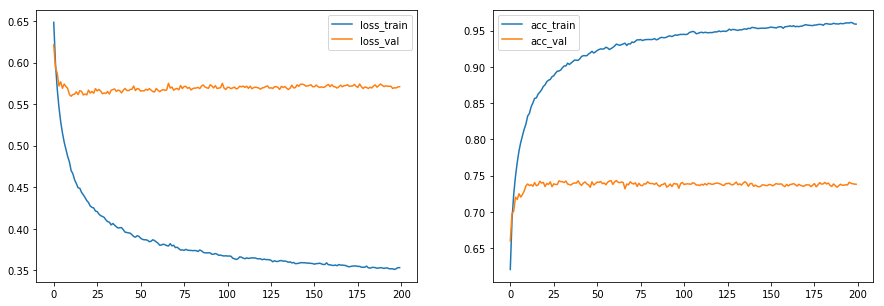

In [169]:
%matplotlib inline
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
for part in losses.keys():
    ax[0].plot(losses[part],label='loss_'+part)
    ax[0].legend()

for part in acc.keys():
    ax[1].plot(acc[part],label='acc_'+part)
    ax[1].legend()


We see even beyond 100 epochs there is little overfitting as the validation set. However, our model's accuracy plateaus at 74%.

In [170]:
#save our model
#this enables us to reuse the trained model later-on using torch.load()
torch.save(best_model, 'fnn-winner-prediction.torch')

/home/bewo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type FeedForwardNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
